Credits to: Xander Carruth, Hosung Hwang, Utsab Ray

In [ ]:
import collections
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling1D, BatchNormalization
from keras.layers import Conv1D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import numpy as np
import io
import pandas as pd
from numpy import hstack, array
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [ ]:
# single location to define subject_location
subject_count =8

In [ ]:
# upload files
from google.colab import files

uploaded = files.upload()


KeyboardInterrupt: ignored

In [ ]:
#combining sets
def combine_data_x(file1, file2):
  headerList1 = ['time']
  headerList2 = ['xacc','yacc','zacc','xgyr','ygyr','zgyr']
  csv1 = pd.read_csv(io.BytesIO(uploaded[file1]))
  csv2 = pd.read_csv(io.BytesIO(uploaded[file2]))
  csv1 = csv1.to_csv("csv1.csv", header=headerList1, index=False)
  csv2 = csv2.to_csv("csv2.csv", header=headerList2, index=False)
  sub_1 = pd.read_csv("csv1.csv")
  sub_2 = pd.read_csv("csv2.csv")
  for item in headerList2:
    sub_1[item] = sub_2[item]
  return sub_1

def combine_data_y(file1, file2):
  headerList1 = ['time']
  headerList2 = ['class']
  csv1 = pd.read_csv(io.BytesIO(uploaded[file1]))
  csv2 = pd.read_csv(io.BytesIO(uploaded[file2]))
  csv1 = csv1.to_csv("csv1.csv", header=headerList1, index=False)
  csv2 = csv2.to_csv("csv2.csv", header=headerList2, index=False)
  sub_1 = pd.read_csv("csv1.csv")
  sub_2 = pd.read_csv("csv2.csv")
  for item in headerList2:
    sub_1[item] = sub_2[item]
  return sub_1

In [ ]:
def concat_data_x(subject_count):
  df = pd.DataFrame()
  for i in range(subject_count):
    subject = i+1
    if(subject==1):
      trials = 8
    if(subject==2):
      trials = 5
    if(subject==3):
      trials = 3
    if(subject==4):
      trials = 2
    if(subject==5):
      trials = 3
    if(subject==6):
      trials = 3
    if(subject==7):
      trials = 4
    if(subject==8):
      trials = 1
    for x in range(trials):
      df = pd.concat([df, combine_data_x('subject_00'+str(subject)+'_0'+str(trials)+'__x_time.csv',
                                         'subject_00'+str(subject)+'_0'+str(trials)+'__x.csv')],axis=0)
  return df

def concat_data_y(subject_count):
  df = pd.DataFrame()
  for i in range(subject_count):
    subject = i+1
    if(subject==1):
      trials = 8
    if(subject==2):
      trials = 5
    if(subject==3):
      trials = 3
    if(subject==4):
      trials = 2
    if(subject==5):
      trials = 3
    if(subject==6):
      trials = 3
    if(subject==7):
      trials = 4
    if(subject==8):
      trials = 1
    for x in range(trials):
      df = pd.concat([df, combine_data_y('subject_00'+str(subject)+'_0'+str(trials)+'__y_time.csv',
                                         'subject_00'+str(subject)+'_0'+str(trials)+'__y.csv')],axis=0)
  return df




In [ ]:
x_train = concat_data_x(subject_count)
y_train = concat_data_y(subject_count)

In [ ]:
y_train.reset_index()
y_train = y_train.drop(columns='time', axis=1)
x_train = x_train.drop(columns='time', axis=1)

In [ ]:
# Upsampling
Yresampled = np.linspace(0,len(y_train),len(x_train['xgyr']), endpoint=False)
y_array = y_train['class'].to_numpy()
print(len(y_array))
for i in range(len(Yresampled)):
  if(i%4 == 0 and (i/4)<len(y_array)):
    Yresampled[i] = y_array[int(i/4)]
  else:
    Yresampled[i] = float("NaN")
Yresampled = pd.DataFrame(Yresampled, columns = ['class'])
Yresampled = Yresampled['class'].ffill()
y_train = Yresampled

337285


In [ ]:
# Dividing training set into 80% training, 20% validation
valid_set_percent = 0.2
split = int((len(x_train))*(1-valid_set_percent))

X_validation = x_train[split:]
Y_validation = y_train[split:]

X_train = x_train[:split]
Y_train = y_train[:split]


In [ ]:
# Applying SMOTE Oversampling
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE(ratio='minority')


x_train_SMOTE_a, y_train_SMOTE_a = SMOTE.fit_resample(X_train, Y_train)
x_train_SMOTE_b, y_train_SMOTE_b = SMOTE.fit_resample(x_train_SMOTE_a, y_train_SMOTE_a)
# x_validation_SMOTE, y_validation_SMOTE = SMOTE.fit_resample(X_validation, Y_validation)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [ ]:
from collections import Counter
print("After oversampling: ",Counter(y_train_SMOTE_b))

After oversampling:  Counter({0.0: 672071, 1.0: 672071, 2.0: 672071, 3.0: 325060})


In [ ]:
scaler = MinMaxScaler()
x_train_SMOTE_b = scaler.fit_transform(x_train_SMOTE_b)

In [ ]:
x_train_SMOTE = pd.DataFrame(x_train_SMOTE_b, columns = ['xacc','yacc','zacc','xgyr','ygyr','zgyr'])
y_train_SMOTE = pd.DataFrame(y_train_SMOTE_b, columns = ['class'])


In [ ]:
Y_validation = Y_validation.reset_index()

In [ ]:
Y_validation = Y_validation.drop(columns='index',axis=1)
print(Y_validation)

        class
0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
...       ...
269837    0.0
269838    0.0
269839    0.0
269840    0.0
269841    0.0

[269842 rows x 1 columns]


In [ ]:
X_validation = scaler.transform(X_validation)
X_validation = pd.DataFrame(X_validation, columns = ['xacc','yacc','zacc','xgyr','ygyr','zgyr'])

In [ ]:
xacc_t = x_train_SMOTE['xacc'].to_numpy()
yacc_t = x_train_SMOTE['yacc'].to_numpy()
zacc_t = x_train_SMOTE['zacc'].to_numpy()
xgyr_t = x_train_SMOTE['xgyr'].to_numpy()
ygyr_t = x_train_SMOTE['ygyr'].to_numpy()
zgyr_t = x_train_SMOTE['zgyr'].to_numpy()
mclass_t = y_train_SMOTE['class'].to_numpy()
xacc_v = X_validation['xacc'].to_numpy()
yacc_v = X_validation['yacc'].to_numpy()
zacc_v = X_validation['zacc'].to_numpy()
xgyr_v = X_validation['xgyr'].to_numpy()
ygyr_v = X_validation['ygyr'].to_numpy()
zgyr_v = X_validation['zgyr'].to_numpy()
mclass_v = Y_validation['class'].to_numpy()

xacc_t = xacc_t.reshape((len(xacc_t)), 1)
yacc_t = yacc_t.reshape((len(yacc_t)), 1)
zacc_t = zacc_t.reshape((len(zacc_t)), 1)
xgyr_t = xgyr_t.reshape((len(xgyr_t)), 1)
ygyr_t = ygyr_t.reshape((len(ygyr_t)), 1)
zgyr_t = zgyr_t.reshape((len(zgyr_t)), 1)
mclass_t = mclass_t.reshape((len(mclass_t)), 1)
xacc_v = xacc_v.reshape((len(xacc_v)), 1)
yacc_v = yacc_v.reshape((len(yacc_v)), 1)
zacc_v = zacc_v.reshape((len(zacc_v)), 1)
xgyr_v = xgyr_v.reshape((len(xgyr_v)), 1)
ygyr_v = ygyr_v.reshape((len(ygyr_v)), 1)
zgyr_v = zgyr_v.reshape((len(zgyr_v)), 1)
mclass_v = mclass_v.reshape((len(mclass_v)), 1)


np_dataset_train = hstack((xacc_t, yacc_t, zacc_t, xgyr_t, ygyr_t, zgyr_t, mclass_t))
np_dataset_val = hstack((xacc_v, yacc_v, zacc_v, xgyr_v, ygyr_v, zgyr_v, mclass_v))
print(np_dataset_train)

[[ 1.081048e-02  9.736126e+00  8.838737e-01 ... -7.866428e-03
   1.088949e-03  0.000000e+00]
 [ 1.489334e-01  9.680800e+00  7.510666e-01 ...  3.766230e-03
   6.503122e-03  0.000000e+00]
 [ 1.996773e-01  9.789677e+00  8.201076e-01 ... -1.764767e-03
   1.045746e-02  0.000000e+00]
 ...
 [ 9.561449e+00  1.912001e+01  7.896537e+00 ... -2.046022e-01
   4.977858e-01  2.000000e+00]
 [-7.771897e+00  7.477978e+00  1.184773e+01 ... -2.873850e+00
  -1.010648e+00  2.000000e+00]
 [ 2.947378e+00  1.116483e+01  8.891341e+00 ... -1.923521e+00
   2.932576e-01  2.000000e+00]]


In [ ]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
n_steps = 30
# convert into input/output
X, y = split_sequences(np_dataset_train, n_steps)
X_val, y_val = split_sequences(np_dataset_val, n_steps)
print(X.shape, y.shape)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

NameError: ignored

In [ ]:
# define model 1
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
base_history_model = model.fit(X, y, epochs=15, validation_data=(X_val, y_val), verbose=1)


Epoch 1/15
73164/73164 [==============================] - 225s 3ms/step - loss: 0.4480 - accuracy: 0.4538 - val_loss: 1.0184 - val_accuracy: 0.3995
Epoch 2/15
73164/73164 [==============================] - 222s 3ms/step - loss: 0.2542 - accuracy: 0.4976 - val_loss: 1.1066 - val_accuracy: 0.3787
Epoch 3/15
73164/73164 [==============================] - 224s 3ms/step - loss: 0.2274 - accuracy: 0.5040 - val_loss: 1.0586 - val_accuracy: 0.4757
Epoch 4/15
73164/73164 [==============================] - 221s 3ms/step - loss: 0.2137 - accuracy: 0.5077 - val_loss: 1.1598 - val_accuracy: 0.4452
Epoch 5/15
73164/73164 [==============================] - 225s 3ms/step - loss: 0.2061 - accuracy: 0.5097 - val_loss: 1.0992 - val_accuracy: 0.4756
Epoch 6/15
73164/73164 [==============================] - 225s 3ms/step - loss: 0.2000 - accuracy: 0.5113 - val_loss: 1.0325 - val_accuracy: 0.4584
Epoch 7/15
73164/73164 [==============================] - 228s 3ms/step - loss: 0.1965 - accuracy: 0.5117 - val_

In [ ]:
# define model 2
model_2 = Sequential()
model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features), padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=2, padding='same'))

model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=2, padding='same'))

model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=2))

model_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling1D(pool_size=2))

model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))


model_2.add(BatchNormalization())

model_2.add(Dense(1))
model_2.compile(optimizer='Adam', loss='mse', metrics=['accuracy'])

In [ ]:
base_history_model_2 = model_2.fit(X, y, epochs=12, validation_data=(X_val, y_val), verbose=1)

Epoch 1/12
73164/73164 [==============================] - 749s 10ms/step - loss: 0.3192 - accuracy: 0.5006 - val_loss: 0.9998 - val_accuracy: 0.6032
Epoch 2/12
73164/73164 [==============================] - 676s 9ms/step - loss: 0.1366 - accuracy: 0.5466 - val_loss: 0.9724 - val_accuracy: 0.6085
Epoch 3/12
73164/73164 [==============================] - 681s 9ms/step - loss: 0.1139 - accuracy: 0.5525 - val_loss: 1.0817 - val_accuracy: 0.6422
Epoch 4/12
73164/73164 [==============================] - 982s 13ms/step - loss: 0.1009 - accuracy: 0.5553 - val_loss: 0.9707 - val_accuracy: 0.6607
Epoch 5/12
73164/73164 [==============================] - 862s 12ms/step - loss: 0.0943 - accuracy: 0.5568 - val_loss: 1.0037 - val_accuracy: 0.6547
Epoch 6/12
73164/73164 [==============================] - 790s 11ms/step - loss: 0.0879 - accuracy: 0.5585 - val_loss: 0.9507 - val_accuracy: 0.6770
Epoch 7/12
73164/73164 [==============================] - 686s 9ms/step - loss: 0.0845 - accuracy: 0.5588 - 

In [ ]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
	  # plot loss
    plt.title('Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='red', label='test')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

    # plot accuracy
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='red', label='test')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

Inference on validation data set


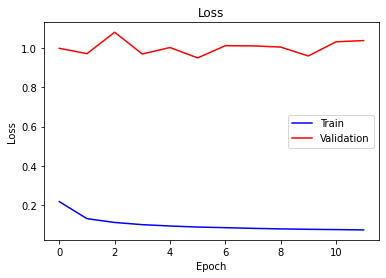

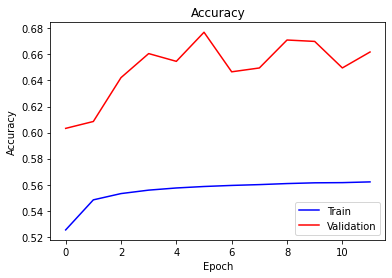

In [ ]:
# plot data
print("Inference on validation data set")
plot_history(base_history_model_2)

In [ ]:
#Calculate metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
prediction2 = model_2.predict(X_val)
yhat_classes = model_2.predict_classes(X_val, verbose=0)
accuracy = accuracy_score(y_val, yhat_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_val, yhat_classes, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, yhat_classes, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, yhat_classes, average='weighted')
print('F1 score: %f' % f1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.661870
Precision: 0.701942
Recall: 0.661870
F1 score: 0.673942


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# predictions
# # upload files for test data
from google.colab import files

uploaded = files.upload()

Saving subject_009_01__x.csv to subject_009_01__x.csv
Saving subject_009_01__x_time.csv to subject_009_01__x_time.csv
Saving subject_009_01__y_time.csv to subject_009_01__y_time.csv
Saving subject_010_01__x.csv to subject_010_01__x.csv
Saving subject_010_01__x_time.csv to subject_010_01__x_time.csv
Saving subject_010_01__y_time.csv to subject_010_01__y_time.csv
Saving subject_011_01__x.csv to subject_011_01__x.csv
Saving subject_011_01__x_time.csv to subject_011_01__x_time.csv
Saving subject_011_01__y_time.csv to subject_011_01__y_time.csv
Saving subject_012_01__x.csv to subject_012_01__x.csv
Saving subject_012_01__x_time.csv to subject_012_01__x_time.csv
Saving subject_012_01__y_time.csv to subject_012_01__y_time.csv


In [ ]:
headerList1 = ['time']
headerList2 = ['xacc','yacc','zacc','xgyr','ygyr','zgyr']



In [ ]:
def split_sequences_x(sequences, n_steps):
	X = list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x= sequences[i:end_ix,:]
		X.append(seq_x)
	return array(X)

In [ ]:
# subject 9 setup
x_test_sub9 = pd.read_csv(io.BytesIO(uploaded['subject_009_01__x.csv']))
x_test_sub9 = x_test_sub9.to_csv("cvs3.csv", header=headerList2, index=False)
x_test_sub9 = pd.read_csv("cvs3.csv")
print(x_test_sub9)

xacc_t = x_test_sub9['xacc'].to_numpy()
yacc_t = x_test_sub9['yacc'].to_numpy()
zacc_t = x_test_sub9['zacc'].to_numpy()
xgyr_t = x_test_sub9['xgyr'].to_numpy()
ygyr_t = x_test_sub9['ygyr'].to_numpy()
zgyr_t = x_test_sub9['zgyr'].to_numpy()

xacc_t = xacc_t.reshape((len(xacc_t)), 1)
yacc_t = yacc_t.reshape((len(yacc_t)), 1)
zacc_t = zacc_t.reshape((len(zacc_t)), 1)
xgyr_t = xgyr_t.reshape((len(xgyr_t)), 1)
ygyr_t = ygyr_t.reshape((len(ygyr_t)), 1)
zgyr_t = zgyr_t.reshape((len(zgyr_t)), 1)

np_dataset_test_sub9 = hstack((xacc_t, yacc_t, zacc_t, xgyr_t, ygyr_t, zgyr_t))
print(np_dataset_test_sub9)


           xacc      yacc      zacc      xgyr      ygyr      zgyr
0      0.413795  8.706898 -4.456205  0.000000 -0.002838  0.007162
1      0.423914  8.707828 -4.502172  0.002037  0.001111  0.007778
2      0.442981  8.718078 -4.502980  0.000403  0.004648  0.008384
3      0.485234  8.725234 -4.520000 -0.000020  0.006667  0.007778
4      0.500000  8.705882 -4.470592  0.000225  0.006636  0.006126
...         ...       ...       ...       ...       ...       ...
37985  0.930160  9.009839 -3.756774  0.000203  0.000706  0.003739
37986  0.955662  8.983775 -3.763775 -0.001557  0.001610  0.001111
37987  0.930297  9.000000 -3.750178  0.001963  0.002815  0.001629
37988  0.965183  9.015183 -3.780000  0.001557 -0.000111  0.002334
37989  0.985275  9.007637 -3.762912 -0.000535 -0.001838  0.000000

[37990 rows x 6 columns]
[[ 4.137955e-01  8.706898e+00 -4.456205e+00  0.000000e+00 -2.837680e-03
   7.162320e-03]
 [ 4.239138e-01  8.707828e+00 -4.502172e+00  2.036766e-03  1.111111e-03
   7.777778e-03]
 [ 4

In [ ]:
n_steps =30
X = split_sequences_x(np_dataset_test_sub9,n_steps)

In [ ]:
# subject 9 prediction
prediction = model_2.predict(X)


In [ ]:
def upsampling_prediction(prediction):
  Yresampled = np.zeros((int(len(prediction)/4),1), dtype=float)

  for i in range(len(prediction)):
    if(i%4 == 0 and (i/4)<len(Yresampled)):
      Yresampled[int(i/4)] = prediction[i]
  Yresampled = pd.DataFrame(Yresampled, columns = ['class'])
  Yresampled = Yresampled['class'].ffill()

  return Yresampled

In [ ]:
# create CSV file
np.savetxt("subject_009_01__y_prediction.csv", np.rint(upsampling_prediction(prediction)), delimiter=",")

In [ ]:
# subject 10
x_test_sub10 = pd.read_csv(io.BytesIO(uploaded['subject_010_01__x.csv']))
x_test_sub10 = x_test_sub10.to_csv("cvs4.csv", header=headerList2, index=False)
x_test_sub10 = pd.read_csv("cvs4.csv")

xacc_t = x_test_sub10['xacc'].to_numpy()
yacc_t = x_test_sub10['yacc'].to_numpy()
zacc_t = x_test_sub10['zacc'].to_numpy()
xgyr_t = x_test_sub10['xgyr'].to_numpy()
ygyr_t = x_test_sub10['ygyr'].to_numpy()
zgyr_t = x_test_sub10['zgyr'].to_numpy()

xacc_t = xacc_t.reshape((len(xacc_t)), 1)
yacc_t = yacc_t.reshape((len(yacc_t)), 1)
zacc_t = zacc_t.reshape((len(zacc_t)), 1)
xgyr_t = xgyr_t.reshape((len(xgyr_t)), 1)
ygyr_t = ygyr_t.reshape((len(ygyr_t)), 1)
zgyr_t = zgyr_t.reshape((len(zgyr_t)), 1)

np_dataset_test_sub10 = hstack((xacc_t, yacc_t, zacc_t, xgyr_t, ygyr_t, zgyr_t))

In [ ]:
n_steps =30
X_10 = split_sequences_x(np_dataset_test_sub10,n_steps)

In [ ]:
# subject 10 prediction
prediction_10 = model_2.predict(X_10)

In [ ]:
# create CSV file
np.savetxt("subject_010_01__y_prediction.csv", np.rint(upsampling_prediction(prediction_10)), delimiter=",")

In [ ]:
# subject 11
x_test_sub11 = pd.read_csv(io.BytesIO(uploaded['subject_011_01__x.csv']))
x_test_sub11 = x_test_sub11.to_csv("cvs5.csv", header=headerList2, index=False)
x_test_sub11 = pd.read_csv("cvs5.csv")

xacc_t = x_test_sub11['xacc'].to_numpy()
yacc_t = x_test_sub11['yacc'].to_numpy()
zacc_t = x_test_sub11['zacc'].to_numpy()
xgyr_t = x_test_sub11['xgyr'].to_numpy()
ygyr_t = x_test_sub11['ygyr'].to_numpy()
zgyr_t = x_test_sub11['zgyr'].to_numpy()

xacc_t = xacc_t.reshape((len(xacc_t)), 1)
yacc_t = yacc_t.reshape((len(yacc_t)), 1)
zacc_t = zacc_t.reshape((len(zacc_t)), 1)
xgyr_t = xgyr_t.reshape((len(xgyr_t)), 1)
ygyr_t = ygyr_t.reshape((len(ygyr_t)), 1)
zgyr_t = zgyr_t.reshape((len(zgyr_t)), 1)

np_dataset_test_sub11 = hstack((xacc_t, yacc_t, zacc_t, xgyr_t, ygyr_t, zgyr_t))

In [ ]:
n_steps =30
X_11 = split_sequences_x(np_dataset_test_sub11,n_steps)

In [ ]:
# subject 10 prediction
prediction_11 = model_2.predict(X_11)

In [ ]:
# create CSV file
np.savetxt("subject_011_01__y_prediction.csv", np.rint(upsampling_prediction(prediction_11)), delimiter=",")

In [ ]:
# subject 12
x_test_sub12 = pd.read_csv(io.BytesIO(uploaded['subject_012_01__x.csv']))
x_test_sub12 = x_test_sub12.to_csv("cvs6.csv", header=headerList2, index=False)
x_test_sub12 = pd.read_csv("cvs6.csv")

xacc_t = x_test_sub12['xacc'].to_numpy()
yacc_t = x_test_sub12['yacc'].to_numpy()
zacc_t = x_test_sub12['zacc'].to_numpy()
xgyr_t = x_test_sub12['xgyr'].to_numpy()
ygyr_t = x_test_sub12['ygyr'].to_numpy()
zgyr_t = x_test_sub12['zgyr'].to_numpy()

xacc_t = xacc_t.reshape((len(xacc_t)), 1)
yacc_t = yacc_t.reshape((len(yacc_t)), 1)
zacc_t = zacc_t.reshape((len(zacc_t)), 1)
xgyr_t = xgyr_t.reshape((len(xgyr_t)), 1)
ygyr_t = ygyr_t.reshape((len(ygyr_t)), 1)
zgyr_t = zgyr_t.reshape((len(zgyr_t)), 1)

np_dataset_test_sub12 = hstack((xacc_t, yacc_t, zacc_t, xgyr_t, ygyr_t, zgyr_t))

In [ ]:
n_steps =30
X_12 = split_sequences_x(np_dataset_test_sub12,n_steps)

In [ ]:
# subject 10 prediction
prediction_12 = model_2.predict(X_12)

In [ ]:
# create CSV file
np.savetxt("subject_012_01__y_prediction.csv", np.rint(upsampling_prediction(prediction_12)), delimiter=",")